# LOADING THE DATA and PRE-PROCESSING

In [32]:
from sklearn import tree, preprocessing
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

In [33]:
# Loading the final dataframe
df= pd.read_csv("/Users/gopalika14/Desktop/CA_DATA.csv")
df.rename(columns = {'DATE':'YEAR'}, inplace = True)
print(df.columns)
df.head()

Index(['ID', 'LATITUDE', 'LONGITUDE', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'FIRE_CODE', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE',
       'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'FIPS_CODE',
       'FIPS_NAME', 'County', 'YEAR', 'AWND', 'DX90', 'EMXP', 'EMXT', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'NEAR_FID', 'NEAR_DIST'],
      dtype='object')


,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,AWND,DX90,EMXP,EMXT,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST
0,128764,38.900278,-120.002500,FED,FS-FIRESTAT,8525,WAGON,2000,2000/07/03 00:00:00+00,185,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1759,1702.002813
1,128765,38.893889,-120.032222,FED,FS-FIRESTAT,8527,FALLEN,2000,2000/07/07 00:00:00+00,189,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1450,844.446657
2,128766,38.900000,-119.983333,FED,FS-FIRESTAT,8514,HOSPITAL,2000,2000/05/02 00:00:00+00,123,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,99,1141.746990
3,128767,39.016944,-120.125000,FED,FS-FIRESTAT,8518,SIERRA,2000,2000/06/15 00:00:00+00,167,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,172,2029.504605
4,128768,38.851389,-119.968333,FED,FS-FIRESTAT,8528,ONEIDAS III,2000,2000/07/03 00:00:00+00,185,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1868,4435.980601


In [34]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df['MONTH'] = df['DATE'].dt.month
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df['BURN_TIME'] = (pd.to_datetime(df['CONT_DATE']) - df['DATE']).astype(int)+1

In [35]:
drop_vars = ['ID','EMXP','EMXT','TMAX','TMIN','SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'FIRE_CODE','DISCOVERY_DOY', 'DISCOVERY_DATE',
             'DISCOVERY_TIME','STAT_CAUSE_CODE','OWNER_CODE', 'FIPS_CODE', 'FIPS_NAME', 'YEAR',
            'CONT_DATE', 'CONT_DOY', 'CONT_TIME','FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR',
             'STATE', 'FIPS_CODE','NEAR_FID','FIRE_NAME','County']
df= df.drop(drop_vars, axis=1)
df = df.drop('DATE',axis=1)
#data = data.dropna()
df.head()


,LATITUDE,LONGITUDE,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,AWND,DX90,PRCP,TAVG,NEAR_DIST,MONTH,DAY_OF_WEEK,BURN_TIME
0,38.900278,-120.002500,2000,Campfire,0.1,5.0,1.0,NaN,44.0,1702.002813,7,0,1
1,38.893889,-120.032222,2000,Campfire,0.1,5.0,1.0,NaN,44.0,844.446657,7,4,1
2,38.900000,-119.983333,2000,Children,0.1,5.0,1.0,NaN,44.0,1141.746990,5,1,1
3,39.016944,-120.125000,2000,Smoking,1.0,5.0,1.0,NaN,44.0,2029.504605,6,3,1
4,38.851389,-119.968333,2000,Campfire,0.1,5.0,1.0,NaN,44.0,4435.980601,7,0,1


In [36]:
#taking care of null or missing values
from sklearn.impute import SimpleImputer
le = preprocessing.LabelEncoder()
#data['STAT_CAUSE_DESCR'] = le.fit_transform(data['STAT_CAUSE_DESCR'])
df['DX90'] = df['DX90'].fillna(0)
imp_median = SimpleImputer(strategy = "median")
df[['AWND']] = imp_median.fit_transform(df[['AWND']]).ravel() 
df[['PRCP']] = imp_median.fit_transform(df[['PRCP']]).ravel()
df[['TAVG']] = imp_median.fit_transform(df[['TAVG']]).ravel()
df.isnull().sum()

LATITUDE            0
LONGITUDE           0
FIRE_YEAR           0
STAT_CAUSE_DESCR    0
FIRE_SIZE           0
AWND                0
DX90                0
PRCP                0
TAVG                0
NEAR_DIST           0
MONTH               0
DAY_OF_WEEK         0
BURN_TIME           0
dtype: int64

## ASSIGNING LABEL

In [37]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     



In [38]:
df['LABEL'] = df['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
df = df.drop('STAT_CAUSE_DESCR',axis=1)
#data_1 = data_1.drop('DATE',axis=1)
#data = data.dropna()
df.head()

,LATITUDE,LONGITUDE,FIRE_YEAR,FIRE_SIZE,AWND,DX90,PRCP,TAVG,NEAR_DIST,MONTH,DAY_OF_WEEK,BURN_TIME,LABEL
0,38.900278,-120.002500,2000,0.1,5.0,1.0,11.85,44.0,1702.002813,7,0,1,2
1,38.893889,-120.032222,2000,0.1,5.0,1.0,11.85,44.0,844.446657,7,4,1,2
2,38.900000,-119.983333,2000,0.1,5.0,1.0,11.85,44.0,1141.746990,5,1,1,2
3,39.016944,-120.125000,2000,1.0,5.0,1.0,11.85,44.0,2029.504605,6,3,1,2
4,38.851389,-119.968333,2000,0.1,5.0,1.0,11.85,44.0,4435.980601,7,0,1,2


In [8]:
df.groupby('LABEL').count()

,LATITUDE,LONGITUDE,FIRE_YEAR,FIRE_SIZE,AWND,DX90,PRCP,TAVG,NEAR_DIST,MONTH,DAY_OF_WEEK,BURN_TIME
LABEL,,,,,,,,,,,,
1,9095,9095,9095,9095,9095,9095,9095,9095,9095,9095,9095,9095
2,17364,17364,17364,17364,17364,17364,17364,17364,17364,17364,17364,17364
3,4321,4321,4321,4321,4321,4321,4321,4321,4321,4321,4321,4321
4,22348,22348,22348,22348,22348,22348,22348,22348,22348,22348,22348,22348


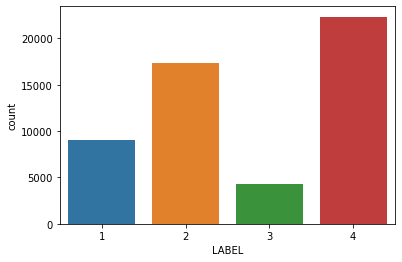

In [9]:
# explore created binary popular measure
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='LABEL',data= df)
plt.show()

In [39]:
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, shuffle=True)

In [11]:
# GAUSSIAN NAIVE BAYES

In [12]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predict_NB = gnb.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predict_NB, y_test ))
#print(1- accuracy_score(predict_NB, y_test))

0.30528891398456615


In [14]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predict_NB))

              precision    recall  f1-score   support

           1       0.22      0.96      0.35      2722
           2       0.00      0.00      0.00      5190
           3       0.00      0.00      0.00      1328
           4       0.57      0.34      0.42      6699

    accuracy                           0.31     15939
   macro avg       0.20      0.32      0.19     15939
weighted avg       0.28      0.31      0.24     15939



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


from sklearn.metrics import accuracy_score
def CrossValid(X,y,k,model):
    scores = []
    cv = KFold(n_splits = k , shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append((accuracy_score(y_test, pred)))
    return (np.mean(scores))   

In [15]:
import numpy as np
import pandas as pd
import csv
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics 
from matplotlib import pyplot as plt
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_cv = np.array(X)
y_cv = np.array(y)
y_cv = np.ravel(y_cv)
kfolds = [5,10]
linda = LinearDiscriminantAnalysis()
log = LogisticRegression()
for k in kfolds:
    print("%s- k-fold Cross validation accuracy score for LDA: %s" %(k,CrossValid(X_cv,y_cv,k,linda)))
    print("%s- k-fold Cross validation accuracy score for Logistic Regression: %s" %(k,CrossValid(X_cv,y_cv,k,log)))

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred_desctree = dt.predict(X_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [30]:
#Adaboost Classifier

# test dataset
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
n_estimators = [100,200,300]
for n in n_estimators:
    abc =AdaBoostClassifier(n_estimators=n, base_estimator=dt,learning_rate=1)
    model = abc.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_t = model.predict(X_train)
    print("Accuracy for n = %s is %s "%(n,metrics.accuracy_score(y_test, y_pred)))
   # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print ("Error for n = %s is %s"%(n,(1-metrics.accuracy_score(y_test, y_pred))))
    print("Precision for n = %s is %s "%(n,metrics.precision_score(y_test, y_pred,average = 'micro')))
    print("Recall for n = %s is %s "%(n,metrics.recall_score(y_test, y_pred, average = 'micro')))
    #print (classification_report(y_test, y_pred))

Accuracy for n = 100 is 0.5851684547336721 
Error for n = 100 is 0.41483154526632793
Precision for n = 100 is 0.5851684547336721 
Recall for n = 100 is 0.5851684547336721 
Accuracy for n = 200 is 0.5774515339732731 
Error for n = 200 is 0.4225484660267269
Precision for n = 200 is 0.5774515339732731 
Recall for n = 200 is 0.5774515339732731 
Accuracy for n = 300 is 0.5876152832674572 
Error for n = 300 is 0.41238471673254284
Precision for n = 300 is 0.5876152832674572 
Recall for n = 300 is 0.5876152832674572 


In [ ]:
# testing dataset
from sklearn.ensemble import RandomForestClassifier
n_estimators = [50,100,150]
for n in n_estimators:
    classifier = RandomForestClassifier(n_estimators = n, criterion = 'entropy', random_state = 0)
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    y_pred_tr = classifier.predict(X_train)
    print("Accuracy for n = %s is %s "%(n,metrics.accuracy_score(y_test, pred)))
    print ("Error for n = %s is %s"%(n,(1-metrics.accuracy_score(y_test, pred))))
    print("Precision for n = %s is %s "%(n,metrics.precision_score(y_test, pred)))
    print("Recall for n = %s is %s "%(n,metrics.recall_score(y_test, pred)))

In [ ]:
feature_scores = classifier.feature_importances_

features_df = pd.DataFrame({'Features': X_train, 'Importance Score': feature_scores})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.plot(x='Features',y='Importance Score',kind='bar')
plt.title('Feature Importance Scores')
plt.show()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

clf= MultinomialNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("score of Naive Bayes algo is :" , score)
y_pred_mnb = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred_mnb))
print (classification_report(y_test, y_pred_mnb))

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print (accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
from sklearn.metrics import classification_report
print (classification_report(y_test, knn_predictions))

0.463768115942029
              precision    recall  f1-score   support

           1       0.52      0.62      0.57      2722
           2       0.38      0.40      0.39      5190
           3       0.18      0.03      0.06      1328
           4       0.51      0.54      0.52      6699

    accuracy                           0.46     15939
   macro avg       0.40      0.40      0.38     15939
weighted avg       0.44      0.46      0.45     15939



In [17]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc.predict(X_test)
pred_gbc = gbc.predict(X_test)
cm = confusion_matrix(y_test, pred_gbc) 
from sklearn.metrics import classification_report
print (classification_report(y_test, pred_gbc))
from sklearn.metrics import accuracy_score
print(accuracy_score(pred_gbc, y_test ))

              precision    recall  f1-score   support

           1       0.71      0.73      0.72      2722
           2       0.49      0.42      0.45      5190
           3       0.53      0.08      0.14      1328
           4       0.57      0.72      0.64      6699

    accuracy                           0.57     15939
   macro avg       0.58      0.49      0.49     15939
weighted avg       0.56      0.57      0.55     15939

0.5714913106217454


import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score



# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state= 0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

# Neural Network

In [18]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding,GRU,LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras import optimizers 
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
df.LABEL.value_counts()
#highest value after Miscellaneous is Accidental tag 

4    22348
2    17364
1     9095
3     4321
Name: LABEL, dtype: int64

In [26]:
print('Build model...')
nn_mod = Sequential()
# hidden layer 1
nn_mod.add(Dense(12, input_dim=12, activation='relu'))
# add dropout for regularization 
nn_mod.add(Dropout(0.2))
nn_mod.add(Dense(25, activation='softmax'))
nn_mod.add(Dropout(0.2))
nn_mod.add(Dense(10, activation='softmax'))
nn_mod.add(Dropout(0.2))
# output
nn_mod.add(Dense(1, activation='softmax'))

# add optimizer, compile, loss, metrics
nn_mod.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print('Summary of the built model')
nn_mod.summary()


Build model...
Summary of the built model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_9 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 25)                325       
_________________________________________________________________
dropout_10 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                260       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (De

In [27]:
#eval_mod(nn_mod, trainX, trainY, testX, testY)
hist = nn_mod.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.3)


Epoch 1/5
102/102 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.1702 - val_loss: 0.0000e+00 - val_accuracy: 0.1742
Epoch 2/5
102/102 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.1702 - val_loss: 0.0000e+00 - val_accuracy: 0.1742
Epoch 3/5
102/102 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.1702 - val_loss: 0.0000e+00 - val_accuracy: 0.1742
Epoch 4/5
102/102 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.1702 - val_loss: 0.0000e+00 - val_accuracy: 0.1742
Epoch 5/5
102/102 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.1702 - val_loss: 0.0000e+00 - val_accuracy: 0.1742


In [30]:
# metrics print neural network 
def eval_mod(model, Xtrain, ytrain, Xtest, ytest):
    # train and predict
    tr_metrics = model.evaluate(Xtrain, ytrain)
    te_metrics = model.evaluate(Xtest, ytest)
    
    # print metrics
    print('\033[1mTraining Metrics - \033[0m')
    print(' Cross-entropy loss: ', tr_metrics[0])
    print(' Accuracy: ', tr_metrics[1], '\tError:', 1-tr_metrics[1])
    print('\033[1mTesting Metrics - \033[0m')
    print(' Cross-entropy loss: ', te_metrics[0])
    print(' Accuracy: ', te_metrics[1], '\tError:', 1-te_metrics[1])
    
    te_preds = model.predict_classes(Xtest)
    print(' Precision: ',metrics.precision_score(ytest, te_preds, average='macro'))
    print(' Recall: ', metrics.recall_score(ytest, te_preds, average='macro'))
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(ytest, te_preds, labels=[0,1]))
    #print("AUC: " + str(roc_auc_score(ytest, te_preds)))

In [31]:
eval_mod(nn_mod, X_train, y_train, X_test, y_test)

499/499 [==============================] - 0s 905us/step - loss: 0.0000e+00 - accuracy: 0.1708
Training Metrics - 
 Cross-entropy loss:  0.0
 Accuracy:  0.17136788368225098 	Error: 0.828632116317749
Testing Metrics - 
 Cross-entropy loss:  0.0
 Accuracy:  0.17077608406543732 	Error: 0.8292239159345627
 Precision:  0.04269402095489052
 Recall:  0.25
Confusion Matrix:
[[   0    0]
 [   0 2722]]


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [43]:
print(X_train.shape)
print(X_test.shape)

(37189, 12)
(15939, 12)


In [59]:

# Importing the Keras libraries and packages to use Tensor Flow Backend
import keras
from keras.models import Sequential #For Initializing ANN
from keras.layers import Dense #For Layers of ANN
# Initializing the ANN with sequence of layers (Could use a Graph)
#Classifier Model
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
# Adding the hidden layers
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
# Probability for the outcome 

#classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN

#Another Option: categorical_crossentropy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])